In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from glob import glob

In [3]:
import sys
sys.version

'3.8.10 (default, Nov 26 2021, 20:14:08) \n[GCC 9.3.0]'

In [50]:
# path to detectin results
detect_res_path = "detection_res_darknet/"
detect_labels_res_path = os.path.join(detect_res_path, "labels")

# path to true labels
true_labeled_imgs_path = "../create_train_set/data/rgb_images_spag_&_bckg"
true_labels_path = "yolo-labels/"

In [51]:
detect_res_img_paths = glob(os.path.join(detect_res_path, "*"))
detect_txt_res_paths = glob(os.path.join(detect_labels_res_path, "*"))

true_labeled_img_paths = glob(os.path.join(true_labeled_imgs_path, "*"))
true_labels_paths = glob(os.path.join(true_labels_path, "*"))

In [52]:
detect_res_img_paths = [name for name in detect_res_img_paths if "." in name]

In [53]:
def get_basename_no_ext(inp):
    return os.path.splitext(os.path.basename(inp[0]))[0]

def get_basenames_no_ext_arr(arr):
    arr_base = np.array(arr).reshape(-1,1)
    arr_base = [os.path.splitext(os.path.basename(inp[0]))[0] for inp in arr_base]
#     arr_base = np.apply_along_axis(get_basename_no_ext, 1, arr_base)
    return arr_base

def read_conf(img_name, detect_txt_res_paths):
    detect_txt_res_paths_base = get_basenames_no_ext_arr(detect_txt_res_paths)
    img_name_no_ext = os.path.splitext(os.path.basename(img_name))[0]
#     print(detect_txt_res_paths_base)
    if img_name_no_ext not in detect_txt_res_paths_base:
        return None
    txt_path = f"{os.path.dirname(detect_txt_res_paths[0])}/{img_name_no_ext}.txt"
    conf = []
    with open(txt_path) as fp:
        for line in fp:
            line = line.split(" ")
            if len(line) == 5:
                # print("ERROR: no conf saved")
                continue
            conf.append(float(line[5].strip()))
    return conf

def check_existance(img_name, true_labels_paths):
    true_labels_paths_base = get_basenames_no_ext_arr(true_labels_paths)
    img_name_no_ext = os.path.splitext(os.path.basename(img_name))[0]
    if img_name_no_ext in true_labels_paths_base:
        return True
    else:
        return False

def get_rows(detect_res_img_paths, detect_txt_res_paths, true_labeled_img_paths, true_labels_paths):
    rows = []
    for img_name in detect_res_img_paths:
        conf = read_conf(img_name, detect_txt_res_paths)
        true_result = check_existance(img_name, true_labels_paths)
        is_valid = check_existance(img_name, true_labeled_img_paths)
        
        im_name_base = os.path.basename(img_name)
        if conf is not None:
            for box_conf in conf:
                rows.append([im_name_base, box_conf, true_result, is_valid])
        else:
            rows.append([im_name_base, 0.0, true_result, is_valid])
    return rows

In [54]:
rows = get_rows(detect_res_img_paths, detect_txt_res_paths, true_labeled_img_paths, true_labels_paths)
rows_df = pd.DataFrame(rows, columns=['img_name', 'conf', 'true_res', 'is_valid'])

In [55]:
len(set(rows_df.img_name))

152

In [41]:
check_existance("125._69324630_squiggles.jpg", true_labels_paths)

True

In [56]:
rows_df_grouped = rows_df.groupby(['img_name'])
imgs = rows_df.img_name.unique()
false_positives = pd.DataFrame()
for img in imgs:
    img_group = rows_df_grouped.get_group(img)
    
    # in event of false positive
    for bbox in range(len(img_group)):
        row = img_group.iloc[bbox]
        if (row.true_res == False) and (row.conf != 0.0):
            false_positives = false_positives.append(row)
    # break


In [72]:
rows_df_grouped = rows_df.groupby(['img_name'])
imgs = rows_df.img_name.unique()
true_positives = pd.DataFrame()
for img in imgs:
    img_group = rows_df_grouped.get_group(img)
    img_group = img_group.sort_values(by=['conf'], ascending=False)
    # in event of true positive
#     for bbox in range(len(img_group)):
    row = img_group.iloc[0]
    if (row.true_res == True) and (row.conf != 0.0):
        true_positives = true_positives.append(row)
#         print(row)
    # break

In [73]:
number_bck_images = len(rows_df[rows_df.true_res == False].img_name.unique())
number_bck_images

57

In [74]:
number_spag_images = len(rows_df[rows_df.true_res == True].img_name.unique())
number_spag_images

95

In [75]:
len(rows_df[rows_df.is_valid == True].img_name.unique())

152

In [76]:
false_positives.head()

,img_name,conf,true_res,is_valid
1,109.schermafbeelding-2020-10-08-om-16.50.34-10...,0.03,0.0,1.0
2,109.schermafbeelding-2020-10-08-om-16.50.34-10...,0.01,0.0,1.0
422,369.07_978bd1e7-ac85-4919-803c-62017ed8715f_gr...,0.02,0.0,1.0
579,298.objects-printed-by-3d-printer-isolated-on-...,0.01,0.0,1.0
580,298.objects-printed-by-3d-printer-isolated-on-...,0.02,0.0,1.0


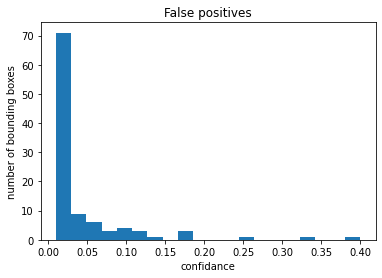

In [77]:
plt.hist(false_positives.conf, bins=20)
plt.ylabel('number of bounding boxes')
plt.xlabel('confidance')
plt.title('False positives');
plt.savefig('false_postives.png')

In [78]:
false_positives.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103 entries, 1 to 2924
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   img_name  103 non-null    object 
 1   conf      103 non-null    float64
 2   true_res  103 non-null    float64
 3   is_valid  103 non-null    float64
dtypes: float64(3), object(1)
memory usage: 4.0+ KB


In [79]:
thresh = 0.3

In [80]:
false_positives[false_positives.conf > thresh].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2 entries, 2288 to 2291
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   img_name  2 non-null      object 
 1   conf      2 non-null      float64
 2   true_res  2 non-null      float64
 3   is_valid  2 non-null      float64
dtypes: float64(3), object(1)
memory usage: 80.0+ bytes


In [81]:
false_positives_total = len(false_positives[false_positives.conf > thresh].img_name.unique())
false_positives_total

1

In [82]:
true_positives.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94 entries, 34 to 2932
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   img_name  94 non-null     object 
 1   conf      94 non-null     float64
 2   true_res  94 non-null     float64
 3   is_valid  94 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.7+ KB


In [83]:
true_positives_total = len(true_positives[true_positives.conf > thresh].img_name.unique())
true_positives_total

70

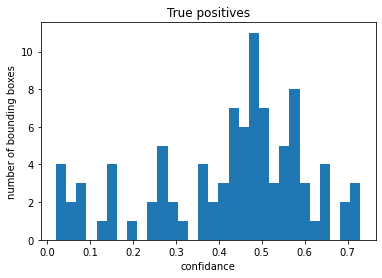

In [86]:
plt.hist(true_positives.conf, bins=30)
plt.ylabel('number of bounding boxes')
plt.xlabel('confidance')
plt.title('True positives');
plt.savefig('true_postives.png')

In [55]:
accuracy = (true_positives_total + number_bck_images - false_positives_total) / (number_bck_images+number_spag_images)
accuracy

0.8758169934640523

In [57]:
precision = true_positives_total / (true_positives_total+false_positives_total)
precision

0.9324324324324325

In [58]:
recall = true_positives_total / number_spag_images
recall

0.8313253012048193

In [181]:
## json to txt
import json
json_files = glob("detection_res_darknet/labels_json/*")
for json_file in json_files:
    with open(json_file, 'r') as f:
      data = json.load(f)
    if (len(data) == 0): continue
    filename_no_ext = os.path.splitext(os.path.basename(json_file))[0]
    print(os.path.splitext(os.path.basename(json_file)))
    txt_file = f"detection_res_darknet/labels/{filename_no_ext}.txt"
    print(txt_file)
    with open(txt_file, "x") as f:
        for bbox in data:
            line = f"0 0 0 0 0 {bbox['confidence']}\n"
            f.write(line)

('217.e2ulul9wea0atw3_out', '.json')
detection_res_darknet/labels/217.e2ulul9wea0atw3_out.txt
('253.811cf1cd-5db3-4797-9d1d-e989442202ee_1.968fd85df6c6f52fdb32e75150d7917d_out', '.json')
detection_res_darknet/labels/253.811cf1cd-5db3-4797-9d1d-e989442202ee_1.968fd85df6c6f52fdb32e75150d7917d_out.txt
('243.3dprinter-2048px-9396_out', '.json')
detection_res_darknet/labels/243.3dprinter-2048px-9396_out.txt
('24.print-quality-1-50f2f759b108acd4c9505e7d5ece4e0e_out', '.json')
detection_res_darknet/labels/24.print-quality-1-50f2f759b108acd4c9505e7d5ece4e0e_out.txt
('54.vzzh4e8q0l8y_out', '.json')
detection_res_darknet/labels/54.vzzh4e8q0l8y_out.txt
('25.why-3d-printed-food-is-the-future_out', '.json')
detection_res_darknet/labels/25.why-3d-printed-food-is-the-future_out.txt
('1.image-asset_img_5eb0af2d092e0_out', '.json')
detection_res_darknet/labels/1.image-asset_img_5eb0af2d092e0_out.txt
('17.dexps9i_out', '.json')
detection_res_darknet/labels/17.dexps9i_out.txt
('279.e3ctcf1x0acowko_out', 

In [182]:
json_files = glob("detection_res_darknet/labels/*")
for json_file in json_files:
    json_file_new = json_file.replace("_out", "")
    print(json_file_new)
    os.rename(json_file, json_file_new)

detection_res_darknet/labels/268.spaghetti-detective.txt
detection_res_darknet/labels/8.3d-printer-spaghetti.txt
detection_res_darknet/labels/66.printing-spaghetti-monster.txt
detection_res_darknet/labels/125._69324630_squiggles.txt
detection_res_darknet/labels/362.3d-printing-1200x410.txt
detection_res_darknet/labels/235.image_thumb-3.txt
detection_res_darknet/labels/116.c67fc3f48c57445ca245ba82257305185d36090f.txt
detection_res_darknet/labels/19.strings.txt
detection_res_darknet/labels/228.010c50a3ad85bdf51f8f8771482a79839e7498c3_2_500x500.txt
detection_res_darknet/labels/9.filament-gone-wrong-770x410.txt
detection_res_darknet/labels/12.3d-printing-tips_4_9_2015.txt
detection_res_darknet/labels/298.objects-printed-by-3d-printer-isolated-on-white-background-picture-id897850542.txt
detection_res_darknet/labels/312.61d9f797a992299485593882_screen%20shot%202022-01-08%20at%2012.43.46%20pm.txt
detection_res_darknet/labels/217.e2ulul9wea0atw3.txt
detection_res_darknet/labels/104.yi6qlqq.txt

In [114]:
imgs = glob("detection_res_darknet/*")
for img in imgs:
    json_file_new = img.replace("_out", "")
    os.rename(img, json_file_new)